# Projet 4: Anticipez les besoins en consommation électrique des bâtiments
## Notebook de modélisation de SiteEnergyUse
*Julie Neury-ormanni*

## Sommaire <a class="anchor" id="sommaire"></a>
## [Import des librairies](#1)<a class="anchor" id="sommaire"></a>
## [Chargement des données](#2)<a class="anchor" id="sommaire"></a>
## [Préparation des données](#3)<a class="anchor" id="sommaire"></a>
### [Sélection des features](#4)<a class="anchor" id="sommaire"></a>
### [Sélection de la target (y)](#5)<a class="anchor" id="sommaire"></a>
### [Définition des fonctions des modèles](#6)<a class="anchor" id="sommaire"></a>
#### [Fonction d'estimation des meilleurs paramètres](#7)<a class="anchor" id="sommaire"></a>
#### [Fonction d'évaluation des métriques](#8)<a class="anchor" id="sommaire"></a>
## [Régression linéaire](#9)<a class="anchor" id="sommaire"></a>
### [Régression linéaire classique](#10)<a class="anchor" id="sommaire"></a>
#### [Régression de Ridge](#11)<a class="anchor" id="sommaire"></a>
##### [Estimation des meilleurs paramètres](#12)<a class="anchor" id="sommaire"></a>
##### [Modéliser avec les meilleurs paramètres](#13)<a class="anchor" id="sommaire"></a>
#### [Régression Lasso](#14)<a class="anchor" id="sommaire"></a>
##### [Estimation des meilleurs paramètres](#15)<a class="anchor" id="sommaire"></a>
##### [Modéliser avec les meilleurs paramètres](#16)<a class="anchor" id="sommaire"></a>
#### [Régression ElasticNet](#17)<a class="anchor" id="sommaire"></a>
##### [Estimation des meilleurs paramètres](#18)<a class="anchor" id="sommaire"></a>
##### [Modéliser avec les meilleurs paramètres](#19)<a class="anchor" id="sommaire"></a>
### [Conclusion](#20)<a class="anchor" id="sommaire"></a>
## [Méthodes ensemblistes](#21)<a class="anchor" id="sommaire"></a>
### [Random Forest Regressor](#22)<a class="anchor" id="sommaire"></a>
#### [Estimation des meilleurs paramètres](#23)<a class="anchor" id="sommaire"></a>
#### [Modéliser avec les meilleurs paramètres](#24)<a class="anchor" id="sommaire"></a>
#### [L'importance des variables](#25)<a class="anchor" id="sommaire"></a>
#### [Conclusion](#26)<a class="anchor" id="sommaire"></a>
### [XG-Boost](#27)<a class="anchor" id="sommaire"></a>
#### [Estimation des meilleurs paramètres](#28)<a class="anchor" id="sommaire"></a>
#### [Modéliser avec les meilleurs paramètres](#29)<a class="anchor" id="sommaire"></a>
#### [L'importance des variables](#30)<a class="anchor" id="sommaire"></a>
#### [Conclusion](#31)<a class="anchor" id="sommaire"></a>
## [Barchart de comparaison des modèles](#32)<a class="anchor" id="sommaire"></a>
## [Choix du modèle et extraction des valeurs prédites](#33)<a class="anchor" id="sommaire"></a>

------

## [Import des librairies](#sommaire)<a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
import timeit
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import shap

## [Chargement des données](#sommaire)<a class="anchor" id="2"></a>

In [3]:
train = pd.read_csv(r'C:\Users\neury\Documents\Python\P4\entrees\train.csv', index_col = [0])
test = pd.read_csv(r'C:\Users\neury\Documents\Python\P4\entrees\test.csv', index_col = [0])

## [Préparation des données](#sommaire)<a class="anchor" id="3"></a>

future_target = ['SteamUse(kBtu)log',
 'Electricity(kBtu)log',
 'NaturalGas(kBtu)log',
 'TotalGHGEmissionslog',
 'Otherlog']

### [Sélection des features](#sommaire)<a class="anchor" id="4"></a>

In [4]:
features = ['YearBuilt', 'NumberofBuildingslog',
       'NumberofFloorslog', 'PropertyGFATotallog', 'PropertyGFAParkinglog',
       'SecondLargestPropertyUseTypeGFAlog',
       'ThirdLargestPropertyUseTypeGFAlog',
       'BuildingType_Campus',
       'BuildingType_Multifamily HR (10+)',
       'BuildingType_Multifamily LR (1-4)',
       'BuildingType_Multifamily MR (5-9)', 'BuildingType_NonResidential',
       'BuildingType_Restaurant', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_High-Rise Multifamily',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mid-Rise Multifamily',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Non-Refrigerated Warehouse',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility', 'Neighborhood_ballard',
       'Neighborhood_central', 'Neighborhood_delridge',
       'Neighborhood_downtown', 'Neighborhood_east',
       'Neighborhood_greater duwamish', 'Neighborhood_lake union',
       'Neighborhood_magnolia / queen anne', 'Neighborhood_north',
       'Neighborhood_northeast', 'Neighborhood_northwest',
       'Neighborhood_southeast', 'Neighborhood_southwest']

### [Sélection de la target (y)](#sommaire)<a class="anchor" id="5"></a>

In [5]:
y_train = train['SiteEnergyUse(kBtu)log']
X_train = train[features]
y_test = test['SiteEnergyUse(kBtu)log']
X_test = test[features]

In [6]:
# Création d'un dataframe dans lequel seront stockées les performances des modèles testés
model_comparison = pd.DataFrame()

### [Définition des fonctions des modèles](#sommaire)<a class="anchor" id="6"></a>

#### [Fonction d'estimation des meilleurs paramètres](#sommaire)<a class="anchor" id="7"></a>

Pour éviter les répétitions, la fonction gridsearchCV est créée. Elle permet d'utiliser la fonction gridsearchCV de sklearn pour tester différentes combinaisons d'hyperparamètres et de pouvoir extraire les hyperparamètres associés au meilleur R².

In [7]:
# Définir la fonction gridsearchresult pour obtenir les meilleurs hyperparamètre des différents modèle tester
def gridsearchresults(model, param_grid, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=3, n_jobs=-1)
    
    # Ajuster sur les différentes combinaisons de GridSearchCV
    grid_result = grid.fit(X_train, y_train)
    
    #Afficher les meilleurs scores (r²) et meilleurs paramètres
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    
    #Calculer les métrics avec sklearn.metrics et les afficher
    mse = metrics.mean_squared_error(grid.predict(X_test), y_test)
    rmse = np.sqrt(mse) #mse**(0.5)  
    r2 = metrics.r2_score(grid.predict(X_test), y_test)
    
    print("Results of sklearn.metrics:")
    print("RMSE:", rmse)
    print("R-Squared:", r2)

#### [Fonction d'évaluation des métriques](#sommaire)<a class="anchor" id="8"></a>

La fonction suivante calcule les diverses métriques que l'on souhaite interpréter: Mean Absolute error (MAE), Root Mean Squarred Error (RMSE), le R squared et enfin le temps de test des combinaisons; et les retourne dans un dictionnaire.

In [8]:
def calcul_metrics(model,X_train, y_train, X_test, y_test):   
    #Calculer les métrics avec sklearn.metrics et les afficher
    mae = metrics.mean_absolute_error(model.predict(X_test), y_test)
    mse = metrics.mean_squared_error(model.predict(X_test), y_test)
    rmse = np.sqrt(mse) #mse**(0.5)  
    r2 = metrics.r2_score(model.predict(X_test), y_test)
    
    print("Results of sklearn.metrics:")
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    
    return dict(r2 = r2, RMSE = rmse, MAE = mae)

## [Régression linéaire](#sommaire)<a class="anchor" id="9"></a>

### [Régression linéaire classique](#sommaire)<a class="anchor" id="10"></a>

In [9]:
lr  = linear_model.LinearRegression()

# Calculer le temps d'entraînement 
start_time = timeit.default_timer()

# Ajuster les paramètres par rapport au données d'entraînements
lr = lr.fit(X_train, y_train)

duration_lr = timeit.default_timer() - start_time

# Afficher le temps d'entraînement
print ('Durée {:.2f}s'.format(duration_lr))

# Calculer les métriques du modèles et créer un dictionnaire de ces données à insérer dans un df
lr_result = calcul_metrics(lr,X_train, y_train, X_test, y_test)
model_comparison = model_comparison.append(lr_result, ignore_index=True)

Durée 0.08s
Results of sklearn.metrics:
MAE: 0.3677921905883315
MSE: 0.24721781723563768
RMSE: 0.49721003332157093
R-Squared: 0.7064997209862145


#### [Régression de Ridge](#sommaire)<a class="anchor" id="11"></a>

##### [Estimation des meilleurs paramètres](#sommaire)<a class="anchor" id="12"></a>

In [10]:
# Le modèle que l'on souhaite tester
ridge = linear_model.Ridge(normalize = True)

# Création d'une liste d'alpha à tester
n_alphas = 200
alphas = np.logspace(-5 , 5 , n_alphas)

# Liste des paramètres sous forme de dictionnaire pour tester avec gridsearchCV
param_grid = dict(alpha=alphas)

In [11]:
gridsearchresults(ridge, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Score:  0.7758050827966733
Best Params:  {'alpha': 0.01304901978014403}
Results of sklearn.metrics:
RMSE: 0.4969540716677189
R-Squared: 0.7002379512706096


##### [Modéliser avec les meilleurs paramètres](#sommaire)<a class="anchor" id="13"></a>

In [12]:
#Récupérer les meilleurs paramètres suggérés ci-dessus et les renseigner dans modèle
ridge = linear_model.Ridge(alpha = 0.01304901978014403, normalize = True)
start_time = timeit.default_timer()

#Ajuster les données avec le meilleur paramètre recommandé
ridge = ridge.fit(X_train, y_train)

#Calculer le temps d'entraînement du modèle
duration_ridge = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_ridge))

Durée 0.01s


In [13]:
ridge_result = calcul_metrics(ridge,X_train, y_train, X_test, y_test)

Results of sklearn.metrics:
MAE: 0.36759161033939125
MSE: 0.24696334934712424
RMSE: 0.4969540716677189
R-Squared: 0.7002379512706096


In [14]:
model_comparison = model_comparison.append(ridge_result, ignore_index=True)

La valeur de alpha pour laquelle la précision est la plus élevée est de 0.012. Cependant, la précision n'est pas grandement améliorée avec ridge par rapport à la régression linéaire classique.

#### [Régression Lasso](#sommaire)<a class="anchor" id="14"></a>

##### [Estimation des meilleurs paramètres](#sommaire)<a class="anchor" id="15"></a>

In [15]:
# Le modèle que l'on souhaite tester
lasso = linear_model.Lasso(fit_intercept=False, max_iter = 10000)

# Création d'une liste d'alpha à tester
n_alphas = 200
alphas = np.logspace(-5 , 5 , n_alphas)

# Liste des paramètres sous forme de dictionnaire pour tester avec gridsearchCV
param_grid = dict(alpha=alphas)

In [16]:
gridsearchresults(lasso, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Score:  0.7769088402806269
Best Params:  {'alpha': 0.00036123426997094305}
Results of sklearn.metrics:
RMSE: 0.4963139168595354
R-Squared: 0.7033591107748558


##### [Modéliser avec les meilleurs paramètres](#sommaire)<a class="anchor" id="16"></a>

In [17]:
#Récupérer les meilleurs paramètres suggérés ci-dessus et les renseigner dans modèle
lasso = linear_model.Lasso(alpha = 0.00036123426997094305, normalize = True)
start_time = timeit.default_timer()

#Ajuster les données avec le meilleur paramètre recommandé
lasso = lasso.fit(X_train, y_train)

#Calculer le temps d'entraînement du modèle
duration_lasso = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_lasso))

Durée 0.01s


In [18]:
lasso_result = calcul_metrics(lasso,X_train, y_train, X_test, y_test)

Results of sklearn.metrics:
MAE: 0.3741060151542538
MSE: 0.24947888515944475
RMSE: 0.49947861331536986
R-Squared: 0.6716473655173616


In [19]:
model_comparison = model_comparison.append(lasso_result, ignore_index=True)

La valeur de alpha pour laquelle la précision est la plus élevée est de 0.0004. Cependant, la précision n'est pas grandement améliorée avec le lasso par rapport à la régression linéaire classique.

#### [Régression ElasticNet](#sommaire)<a class="anchor" id="17"></a>

##### [Estimation des meilleurs paramètres](#sommaire)<a class="anchor" id="18"></a>

In [20]:
# Le modèle que l'on souhaite tester
elasticnet = linear_model.ElasticNet(fit_intercept=False, max_iter = 10000)

# Création d'une liste d'alpha à tester
n_alphas = 200
alphas = np.logspace(-5 , 5 , n_alphas)
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Liste des paramètres sous forme de dictionnaire pour tester avec gridsearchCV
param_grid = dict(alpha=alphas, l1_ratio=l1_ratio)

In [21]:
gridsearchresults(elasticnet, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 2200 candidates, totalling 11000 fits
Best Score:  0.7769088402806269
Best Params:  {'alpha': 0.00036123426997094305, 'l1_ratio': 1}
Results of sklearn.metrics:
RMSE: 0.4963139168595354
R-Squared: 0.7033591107748558


##### [Modéliser avec les meilleurs paramètres](#sommaire)<a class="anchor" id="19"></a>

In [22]:
#Récupérer les meilleurs paramètres suggérés ci-dessus et les renseigner dans modèle
elasticnet = linear_model.ElasticNet(alpha = 0.00036123426997094305, l1_ratio = 1, normalize = True)
start_time = timeit.default_timer()

#Ajuster les données avec le meilleur paramètre recommandé
elasticnet = elasticnet.fit(X_train, y_train)

#Calculer le temps d'entraînement du modèle
duration_elasticnet = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_elasticnet))

Durée 0.02s


In [23]:
elasticnet_result = calcul_metrics(elasticnet,X_train, y_train, X_test, y_test)

Results of sklearn.metrics:
MAE: 0.3741060151542538
MSE: 0.24947888515944475
RMSE: 0.49947861331536986
R-Squared: 0.6716473655173616


In [24]:
model_comparison = model_comparison.append(elasticnet_result, ignore_index=True)

La valeur de alpha pour laquelle la précision est la plus élevée est de 0.0004 et celle du l1_ratio est de 1. Cela signifie que le régularisateur elasticnet applique une correction similaire à celle du lasso (même valeur d'alpha).

### [Conclusion](#sommaire)<a class="anchor" id="20"></a>

Ci dessus, les régularisateurs n'améliorent pas la précision du modèle. La différence entre le R² du jeu de donnée train et celui du jeu de donnée test démontre une perte de précision de 7% sur les prédictions test.
Nous allons donc tester des méthodes ensemblistes pour essayer d'améliorer la précision de la prédiction.

## [Méthodes ensemblistes](#sommaire)<a class="anchor" id="21"></a>

### [Random Forest Regressor](#sommaire)<a class="anchor" id="22"></a>

#### [Estimation des meilleurs paramètres](#sommaire)<a class="anchor" id="23"></a>

Dans un premier temps, la librairie RandomizedSearchCV permet de tester aléatoirement quelques combinaisons d'hyperparamètres proposés ci-dessous pour réduire le nombre de valeurs à tester par hyperparamètre des modèles et donc le temps d'entraînement sur les différents combinaisons avec GridSearchCV.

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace (start = 2, stop = X_train.shape[1], num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 50, 100, 300, 500]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 25, 50, 150, 250]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators, #Number of trees in the forest
               'max_features': max_features, #max numbers of features considered for splitting a node
               'max_depth': max_depth,# max number of levels in each decision tree
               'min_samples_split': min_samples_split,#min number of data points placed in a node before the node is split
               'min_samples_leaf': min_samples_leaf,#min number of data points allowed in a leaf node
               'bootstrap': bootstrap}# method for sampling data points (with or without replacement)
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [2, 7, 12, 18, 23, 29, 34, 40, 45, 51], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [10, 50, 100, 300, 500], 'min_samples_leaf': [5, 25, 50, 150, 250], 'bootstrap': [True, False]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(
    estimator = rfr, 
    param_distributions = random_grid, 
    n_iter = 100, # number of different combination to try (wider search space)
    cv = 3, #number of folds to use for cross validation (++ reduce overfitting chance)
    verbose=2, 
    random_state=42, 
    n_jobs = -1)
# Fit the random search model
rfr_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [2, 7, 12, 18, 23, 29,
                                                         34, 40, 45, 51],
                                        'min_samples_leaf': [5, 25, 50, 150,
                                                             250],
                                        'min_samples_split': [10, 50, 100, 300,
                                                              500],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
            

In [27]:
rfr_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 18,
 'max_depth': 50,
 'bootstrap': False}

In [28]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40],
    'max_features':[18],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [10, 20, 40],
    'n_estimators': [1600, 1800]
}

# Create a based model
rfr = RandomForestRegressor()

In [29]:
gridsearchresults(rfr, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Score:  0.759062451027199
Best Params:  {'bootstrap': False, 'max_depth': 20, 'max_features': 18, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1800}
Results of sklearn.metrics:
RMSE: 0.49811662869262313
R-Squared: 0.6831987411031707


#### [Modéliser avec les meilleurs paramètres](#sommaire)<a class="anchor" id="24"></a>

In [30]:
rfr =  RandomForestRegressor(bootstrap= False, 
                             max_depth= 20, 
                             max_features= 18, 
                             min_samples_leaf= 5, 
                             min_samples_split=10, 
                             n_estimators= 1800)
start_time = timeit.default_timer()
rfr = rfr.fit(X_train, y_train)
duration_rfr = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_rfr))

Durée 7.56s


In [31]:
rfr_result = calcul_metrics(rfr,X_train, y_train, X_test, y_test)

Results of sklearn.metrics:
MAE: 0.36138311463109263
MSE: 0.24825973326600206
RMSE: 0.49825669415071794
R-Squared: 0.6827185701719327


In [32]:
model_comparison = model_comparison.append(rfr_result, ignore_index=True)

#### [L'importance des variables](#sommaire)<a class="anchor" id="25"></a>

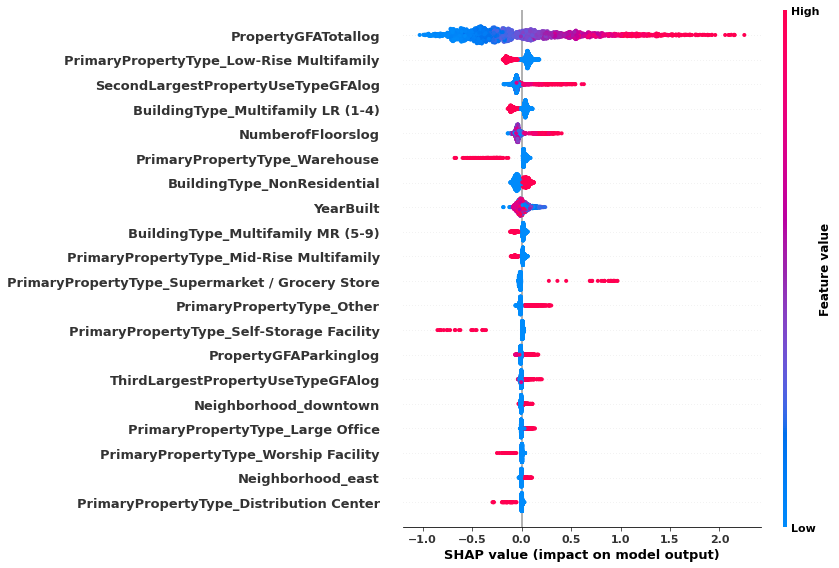

In [33]:
rf_shap_values = shap.TreeExplainer(rfr).shap_values(X_train)
f = plt.figure()
shap.summary_plot(rf_shap_values, X_train)

#### [Conclusion](#sommaire)<a class="anchor" id="26"></a>

Le randomforest testé ci-dessus à partir des meilleurs paramètres sélectionnés par GridSearchCV ne présente pas d'amélioration de la précision par rapport aux régressions linéaires précédentes et une plus grande perte de précision entre le jeu de donnée d'entraînement et le jeu de donnée test.
La variable la plus importante considérée dans le modèle et la surface totale de la propriété: plus elle est élevée, plus la consommation en énergie sur site augmente.

### [XG-Boost](#sommaire)<a class="anchor" id="27"></a>

#### [Estimation des meilleurs paramètres](#sommaire)<a class="anchor" id="28"></a>

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Learning rate (eta)réduit les pondérations
eta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Subsample ratio of columns when constructing each tree
colsample_bytree = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#  subsample ratio of columns for each level
colsample_bylevel = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#subsample ratio of columns for each node (split)
colsample_bynode = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Create the random grid
random_grid = {'n_estimators': n_estimators, 
               'max_depth': max_depth,
               'learning_rate': eta,
               'colsample_bytree': colsample_bytree,
               'colsample_bylevel':colsample_bylevel,
               'colsample_bynode':colsample_bynode}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bytree': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bylevel': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bynode': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}


In [35]:
xg_reg = xgb.XGBRegressor()

xg_reg_random = RandomizedSearchCV(
    estimator = xg_reg, 
    param_distributions = random_grid, 
    n_iter = 100, # number of different combination to try (wider search space)
    cv = 3, #number of folds to use for cross validation (++ reduce overfitting chance)
    verbose=2, 
    random_state=42, 
    n_jobs = -1)
# Fit the random search model
xg_reg_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                                              0.4, 0.5, 0.6,
                                                              0.7, 0.8, 0.9,
                                    

In [36]:
xg_reg_random.best_params_

{'n_estimators': 1000,
 'max_depth': 60,
 'learning_rate': 0.1,
 'colsample_bytree': 0.9,
 'colsample_bynode': 0.5,
 'colsample_bylevel': 0}

In [37]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [800, 1000],
    'max_depth': [40, 50, 60],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.9],
    'colsample_bynode': [0.4, 0.5],
    'colsample_bylevel': [0.1, 0.2]
}

# Create a based model
xg_reg = xgb.XGBRegressor()

In [38]:
gridsearchresults(xg_reg, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Score:  0.7743564576287041
Best Params:  {'colsample_bylevel': 0.1, 'colsample_bynode': 0.4, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 40, 'n_estimators': 800}
Results of sklearn.metrics:
RMSE: 0.4806938168343447
R-Squared: 0.7288550481355937


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


#### [Modéliser avec les meilleurs paramètres](#sommaire)<a class="anchor" id="29"></a>

In [39]:
xg_reg = xgb.XGBRegressor(colsample_bylevel = 0.1, 
                          colsample_bynode = 0.4, 
                          colsample_bytree = 0.7, 
                          learning_rate = 0.1, 
                          max_depth = 40, 
                          n_estimators = 800)
start_time = timeit.default_timer()
xg_reg.fit(X_train, y_train)
duration_xgboost = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_xgboost))

Durée 0.74s


In [40]:
xgboost_result = calcul_metrics(rfr,X_train, y_train, X_test, y_test)

Results of sklearn.metrics:
MAE: 0.36138311463109263
MSE: 0.24825973326600206
RMSE: 0.49825669415071794
R-Squared: 0.6827185701719327


In [41]:
model_comparison = model_comparison.append(xgboost_result, ignore_index=True)

#### [L'importance des variables](#sommaire)<a class="anchor" id="30"></a>

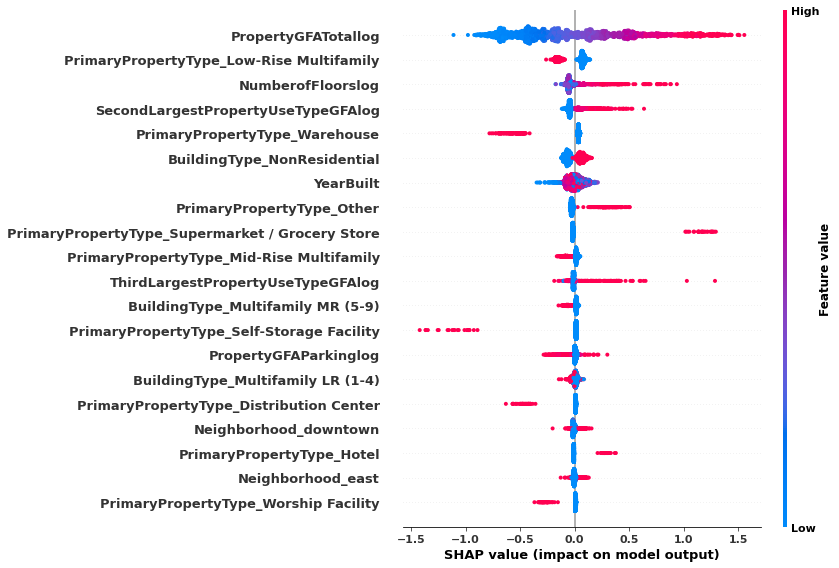

In [43]:
xg_shap_values = shap.TreeExplainer(xg_reg).shap_values(X_train)
f = plt.figure()
shap.summary_plot(xg_shap_values, X_train)

#### [Conclusion](#sommaire)<a class="anchor" id="31"></a>

## [Barchart de comparaison des modèles](#sommaire)<a class="anchor" id="32"></a>

In [44]:
duration = [duration_lr, duration_ridge, duration_lasso, duration_elasticnet, duration_rfr, duration_xgboost]
modele = ['Reg Lin', 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'XgBoost']

In [45]:
model_comparison['duration'] = duration

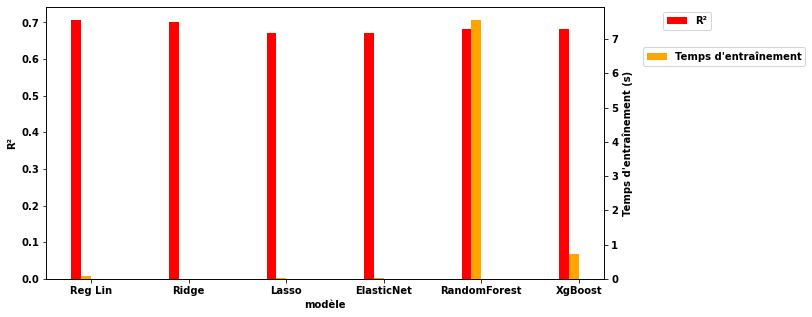

In [46]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.1
ind = np.arange(len(model_comparison))
ax.set_ylabel('R²')
ax2.set_ylabel("Temps d'entraînement (s)")
ax.set_xlabel('modèle')
ax.bar(ind, model_comparison.r2, width, color='red', label = 'R²')
ax2.bar(ind + width, model_comparison.duration, width, color = 'orange', label = "Temps d'entraînement (s)")
ax.set(xticks = (ind + 1.5 * width), xticklabels = modele)
ax.legend(['R²'], bbox_to_anchor = (1.2, 1))
ax2.legend(["Temps d'entraînement"], bbox_to_anchor = (1.06, 0.87))
plt.show()

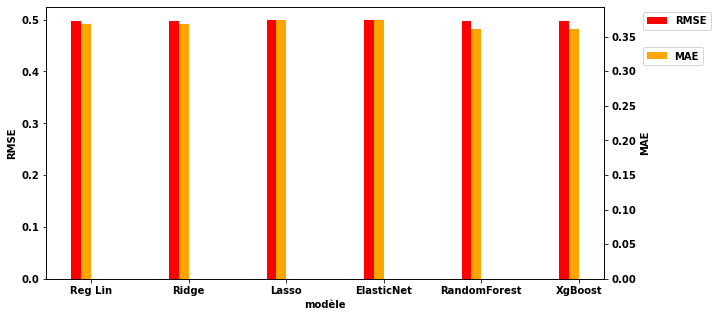

In [48]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.1
ind = np.arange(len(model_comparison))
ax.set_ylabel('RMSE')
ax2.set_ylabel('MAE')
ax.set_xlabel('modèle')
ax.bar(ind, model_comparison.RMSE, width, color='red', label = 'RMSE')
ax2.bar(ind + width, model_comparison.MAE, width, color = 'orange', label = 'MAE')
ax.set(xticks = (ind + 1.5 * width), xticklabels = modele)
ax.legend(['RMSE', 'R²'], bbox_to_anchor = (1.2, 1))
ax2.legend(["MAE"], bbox_to_anchor = (1.06, 0.87))
plt.show()

## [Choix du modèle et extraction des valeurs prédites](#sommaire)<a class="anchor" id="33"></a>